In [34]:
%pylab inline

from library import lasagnennet as LN
from library import features as F
from library import scale as S
from library import validate as V
import numpy as np
import theano as TH
import pandas as pa
import lasagne as L
import sys

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
train_feats = pa.read_csv('full_train_feats.csv')
train_targets = pa.read_csv('full_train_targets.csv')
# val_feats = pa.read_csv('validation_feats.csv')
# val_targets = pa.read_csv('validation_targets.csv')
vval_feats = pa.read_csv('val_train_feats.csv')
vval_targets = pa.read_csv('val_train_targets.csv')

In [3]:
tx = np.asarray(train_feats, dtype=np.float32)
tyall = np.asarray(train_targets, dtype=np.int32)
ty = np.asarray(train_targets['LABEL'], dtype=np.int32).reshape(-1, 1)
# vx = np.asarray(val_feats, dtype=np.float32)
# vyall = np.asarray(val_targets, dtype=np.float32)
# vy = np.asarray(val_targets['LABEL'], dtype=np.float32).reshape(-1, 1)

In [4]:
valx = np.asarray(vval_feats, dtype=np.float32)
valyall = np.asarray(vval_targets, dtype=np.int64)

In [5]:
ty = ty.ravel()
# vy = vy.ravel()

In [6]:
print tx.shape, tyall.shape, ty.shape #, vx.shape, vyall.shape, vy.shape

(628437, 129) (628437, 4) (628437,)


In [7]:
maxtimes = [0 for i in xrange(5000)]
for it, i in enumerate(tyall):
    maxtimes[i[0]] = max(maxtimes[i[0]], it)
maxtimes = set(maxtimes)
maxtimes = np.asarray([i for i in maxtimes])
print maxtimes
lasttimes = [0 for i in xrange(tyall.shape[0])]
for i in maxtimes:
    if tyall[i,2] == 1:
        lasttimes[i] = 1
lasttimes = np.asarray(lasttimes)
print np.sum(lasttimes)

[     0  16385 557058 ..., 494250 516094 468309]
246


In [11]:
tlabels = np.asarray(pa.read_csv('Training_Dataset/id_label_train.csv'))
print tlabels

[[   1    1]
 [   2    1]
 [   3    1]
 ..., 
 [3592    0]
 [3593    0]
 [3594    0]]


In [12]:
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [9]:
clf = svm.SVC(verbose=True, max_iter=200)
clf.fit(tx, ty)

In [74]:
tprobs = clf.decision_function(tx)
# vprobs = clf.decision_function(vx)
valprobs = clf.decision_function(valx)

In [92]:
# thresh = np.percentile(tprobs, 99.3)
thresh = 0.993
newlabels = tprobs >= thresh
newlabels = newlabels.ravel() & (ty==1)
# newlabels = newlabels | (lasttimes==1)
newlabels = np.int32(newlabels)
print np.sum(newlabels)

4405


In [93]:
clf1 = svm.SVC(verbose=True, max_iter=200, class_weight={0:1, 1:10})
clf1.fit(tx, newlabels)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight={0: 1, 1: 10}, coef0=0.0, degree=3,
  gamma=0.0, kernel='rbf', max_iter=200, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=True)

In [88]:
# tprobs = clf1.decision_function(tx)
# vprobs = clf1.decision_function(vx)
valprobs = clf1.decision_function(valx)

In [95]:
num_examples = ty.shape[0]
weights = np.asarray([1 for i in xrange(num_examples)])
for i in xrange(num_examples):
    if ty[i] == 1:
        weights[i] = 1.5

for i in xrange(2):
    clf2 = svm.SVC(max_iter=200)
    clf2.fit(tx, ty, weights)
    prob = clf2.decision_function(tx)
    print 'Done {} ...'.format(i)
    
    maxs = np.asarray([nan for j in xrange(tlabels.shape[0])])
    for j in xrange(num_examples):
        ind = tyall[j,0]-1
        maxs[ind] = np.nanmax((maxs[ind], prob[j]))
    
    thresh = np.percentile(maxs, 99)

    pred = prob >= thresh
    for j in xrange(num_examples):
        if ty[j] == 0 and pred[j]:
            weights[j] = min(100, weights[j]*10)
        if ty[j] == 1 and pred[j]:
            weights[j] = min(1000, weights[j]*100)
        if ty[j] == 1 and not pred[j]:
            weights[j] = max(1, weights[j]/2)
    
    print np.sum(weights)
    
    maxs = np.int32(maxs>=thresh)
    
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for j in xrange(maxs.shape[0]):
        if maxs[j] == 1:
            if tlabels[j,1] == 1:
                tp += 1
            else:
                fp += 1
        else:
            if tlabels[j,1] == 0:
                tn += 1
            else:
                fn += 1
    
    print 'sensitivity = ', tp*1.0/(tp+fn)
    print 'specificity = ', tn*1.0/(tn+fp)
    sys.stdout.flush()

Done 0 ...
737184
sensitivity =  0.0734693877551
specificity =  0.994625261272
Done 1 ...
1773403
sensitivity =  0.134693877551
specificity =  0.999104210212


In [96]:
# tprobs = clf2.decision_function(tx)
# vprobs = clf.decision_function(vx)
valprobs = clf2.decision_function(valx)
print thresh

0.994191586806


0.678517218615


/home/biswajit/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function auc_score is deprecated; Function 'auc_score' has been renamed to 'roc_auc_score' and will be removed in release 0.16.
  warnings.warn(msg, category=DeprecationWarning)


0.695630173164


/home/biswajit/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function auc_score is deprecated; Function 'auc_score' has been renamed to 'roc_auc_score' and will be removed in release 0.16.
  warnings.warn(msg, category=DeprecationWarning)


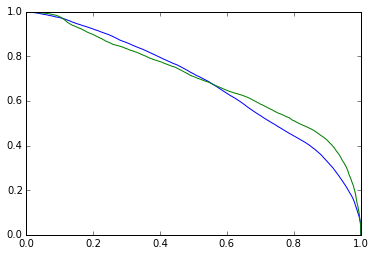

In [20]:
yscore = tprobs.ravel()
fpr, tpr, thresh = roc_curve(ty, yscore)
auc = auc_score(ty, yscore)
print auc
display(pyplot.plot(1-fpr, tpr,))

yscore = vprobs.ravel()
fpr, tpr, thresh = roc_curve(vy, yscore)
auc = auc_score(vy, yscore)
print auc
display(pyplot.plot(1-fpr, tpr,))

In [97]:
# thresh = np.percentile(valprobs.ravel(), 99)
thresh = 0.99
print thresh
pred = np.int32(valprobs.ravel() >= thresh)
print np.sum(pred)

outfile = open('out.csv', 'w')
outfile.write('ID,TIME,LABEL,ICU\n')
for i in xrange(valx.shape[0]):
    if np.int64(valyall[i,2]) == 1:
        outfile.write(str(valyall[i,0])+','+str(valyall[i,1])+','+str(pred[i])+',1\n')
outfile.close()

V.validate('out.csv', './Validation_Data/id_label_val.csv')

0.99
3715
tp :  22 , tn :  1105 , fp :  11 , fn :  60
sensitivity :  0.268292682927 , specificity :  0.990143369176
accuracy :  0.940734557596 median prediction time :  76.5311111111
finalScore :  40.1936358073


(0.2682926829268293,
 0.9901433691756273,
 0.9407345575959933,
 76.531111111111116,
 40.19363580732585)

In [46]:
print np.percentile(valprobs.ravel(), 99.5)
print np.percentile(valprobs.ravel(), 99.3)

0.759480724715
0.759055356111


In [11]:
# thresh = np.percentile(valprobs.ravel(), 99.3)
thresh = 0.7590
print thresh
pred = np.int32(valprobs.ravel() >= thresh)
print np.sum(pred)

outfile = open('output.csv', 'w')
# outfile.write('ID,TIME,LABEL\n')
for i in xrange(valx.shape[0]):
    if np.int64(valyall[i,2]) == 1:
        outfile.write(str(valyall[i,0])+','+str(valyall[i,1])+','+str(pred[i])+'\n')
outfile.close()

0.759
1468


In [53]:
reload(V)
V.validate('out.csv', './Validation_Data/id_label_val.csv')

tp :  22 , tn :  1105 , fp :  11 , fn :  60
sensitivity :  0.268292682927 , specificity :  0.990143369176
accuracy :  0.940734557596 median prediction time :  76.5311111111
finalScore :  40.1936358073


(0.2682926829268293,
 0.9901433691756273,
 0.9407345575959933,
 76.531111111111116,
 40.19363580732585)